This notebook extracts features and then builds ML models for the **real** 5 and 10 nm combined runs (not generated runs)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal
from scipy.signal import find_peaks, peak_widths
import pyabf
import pyabf.filter
from multiprocessing import Pool
import pywt

from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis
import seaborn as sns
from scipy.stats import randint

from matplotlib.ticker import MaxNLocator
import sklearn
from sklearn.cluster import DBSCAN
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from scipy.stats import entropy
from collections import Counter

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import pickle

In [44]:
def unpickle_ML_model(path):
    with open(path, 'rb') as file:
        return pickle.load(file)
        

In [13]:
from all_funcs import *

In [5]:
import importlib
import all_funcs
importlib.reload(all_funcs)
from all_funcs import *

##### Importing and checking data

In [3]:
paths = []
for i in range(1,6):
    paths.append(f"/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/mixed_5_10_runs/p18_7_05XPBS_PEG35k_i2o_1nM_5nmand10nm_AuNP_SDS_000{i}.abf")


In [4]:
def load_to_event_data_nofeatures(path, resistive = False, plot = False, NRNS = False, NP = True):
    x, y, sma, y_corrected, y_base, x_base = importABF_movingavg(path, resistive) 
    
    threshold, mean_noise, sd_noise = define_threshold(y_base, 12)
    
    sd_threshold, sd_threshold_lower, peaks_above, properties_above, peaks_below, properties_below = find_peaks_troughs(mean_noise, sd_noise, y_base, x_base, resistive, plot = plot)
    
    if NRNS: # option for different event isolation function
        event_time, event_data = event_isolation_NRNS(x_base, y_base, peaks_above, NP = NP)
        smo = None
    if resistive:
        event_time, event_data, smo = event_isolation(x_base, y_base, peaks_above, properties_above, peaks_below, properties_below)
    else:
        event_time, event_data, smo = event_isolation(x_base, y_base, peaks_above, properties_above)        
    
    
    return event_time, event_data, smo, sd_threshold, sd_threshold_lower, mean_noise #, peaks_above, peaks_below

In [6]:
data_mixed_df.to_pickle("data_mixed_df.pkl")

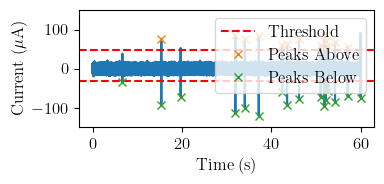

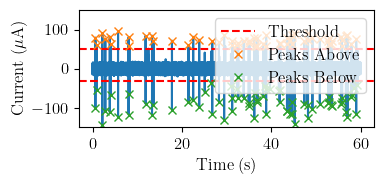

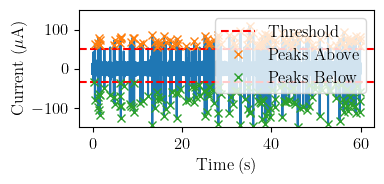

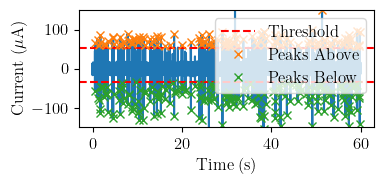

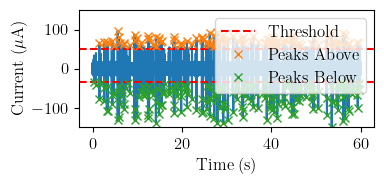

,event_time,event_data,smo,sd_threshold,sd_threshold_lower,mean_noise
run_1,"[[15.386999999999999, 15.387001999999999, 15.3...","[[0.7175842285166709, 0.7168670654307334, 0.74...","[[7693500, 7694500], [15977041, 15977915], [17...",48.081172,-32.056850,-0.001641
run_2,"[[0.630358, 0.6303599999999999, 0.630362, 0.63...","[[2.5127075195325688, 2.7268188476575688, 2.91...","[[315179, 316179], [470372, 470925], [1091685,...",49.145339,-32.766061,-0.001501
run_3,"[[0.525004, 0.525006, 0.525008, 0.52501, 0.525...","[[-6.357226562498909, -6.876266479491051, -7.1...","[[262502, 263502], [601571, 602571], [674207, ...",50.215504,-33.478093,-0.000654
run_4,"[[0.6356539999999999, 0.635656, 0.635658, 0.63...","[[-20.879989624022073, -20.18026733398301, -19...","[[317827, 318827], [553961, 554577], [740836, ...",51.609573,-34.408298,-0.001150
run_5,"[[1.53019, 1.530192, 1.5301939999999998, 1.530...","[[3.8113708496109666, 4.209411621095342, 4.668...","[[765095, 766095], [1288197, 1289184], [158911...",50.574609,-33.716427,-0.000012


In [5]:
data_mixed_df = pd.DataFrame(columns = ["event_time", "event_data", "smo", "sd_threshold", "sd_threshold_lower", "mean_noise"])

for i in range(len(paths)):
    
    data = load_to_event_data_nofeatures(paths[i], resistive = True, plot = True, NRNS = True)
    
    data_mixed_df.loc[f"run_{i+1}"] = data
    
    
data_mixed_df

In [11]:
len(data_mixed_df['event_data'])

5

In [18]:
data_mixed_df = unpickle("data_mixed_df.pkl")

In [138]:
len(data_mixed_df['event_data'])

5

In [19]:
features_mixed_dic = {}
features_mixed_list = []
event_info_mixed_dic = {"DWT_rec":[], "event_time_padded":[], "DWT_rec_padded":[], "all_coeffs":[]}

for i in range(len(data_mixed_df['event_data'])): #no. runs
#for i in range(2,5):
    DWT_rec, event_time_padded, DWT_rec_padded, features_df, features_list, labels, all_coeffs = DWT_and_features_thresh_trace(data_mixed_df["event_time"][i], data_mixed_df["event_data"][i], data_mixed_df["mean_noise"][i], data_mixed_df["sd_threshold"][i], data_mixed_df["sd_threshold_lower"][i], NP_label = None, wavelet = "coif17", threshold = 0.1)
    
    features_mixed_dic["run_"+str(i+1)] = features_list
    features_mixed_list += features_list
    
    event_info_mixed_dic["DWT_rec"].append(DWT_rec)
    event_info_mixed_dic["event_time_padded"].append(event_time_padded)
    event_info_mixed_dic["DWT_rec_padded"].append(DWT_rec_padded)
    event_info_mixed_dic["all_coeffs"].append(all_coeffs)
    
#features_mixed_df = pd.DataFrame(features_mixed_dic)

In [20]:
len(features_mixed_list)

397

In [149]:
len(data_mixed_df.iloc[0]["event_time"]), len(data_mixed_df.iloc[1]["event_time"])

(13, 58)

In [21]:
def centre_peak(time, data):
    """ 

    Args:
        time, data: list of arrays

    Returns:
        centered_time, centered_data
    """
    centered_data = []
    centered_time = []
    for i in range(len(data)):
        peak = np.argmax(data[i])
        shift = 500 - peak
        centered_data.append(np.roll(data[i], shift))
        centered_time.append(np.roll(time[i], shift))
    
    return centered_time, centered_data

In [151]:
len(event_info_mixed_dic["DWT_rec_padded"])

5

In [22]:
DWT_rec_padded_flat = [item for sublist in event_info_mixed_dic["DWT_rec_padded"] for item in sublist]
event_time_padded_flat = [item for sublist in event_info_mixed_dic["event_time_padded"] for item in sublist]

In [23]:
event_time_padded_flat_centred, DWT_rec_padded_flat_centred = centre_peak(event_time_padded_flat, DWT_rec_padded_flat)
event_time_padded_flat_centred = np.array(event_time_padded_flat_centred)
DWT_rec_padded_flat_centred = np.array(DWT_rec_padded_flat_centred)

In [215]:
len(DWT_rec_padded_flat)

397

In [22]:
len(features_mixed_list)

397

In [15]:
from joblib import load

best_model_XG_random_01_coif3 = load('best_model_XG_random_01_coif3.pkl')
best_model_XG_random_015 = load('best_model_XG_random_015.pkl')
best_model_XG_random_01_coif6 = load('best_model_XG_random_01_coif6.pkl')
best_model_XG_random_01_rbio15 = load('best_model_XG_random_01_rbio15.pkl')
best_model_XG_random_01_bior33 = load('best_model_XG_random_01_bior33.pkl')
best_model_XG_random_02_bior33 = load('best_model_XG_random_02_bior33.pkl')

In [16]:
df_events_all_wavelets_thresh015_coeff2 = unpickle('df_events_all_wavelets_thresh015_coeff2.pkl')

In [412]:
len(event_info_mixed_dic["event_time_padded"][0][2])

1000

In [24]:
scaler = RobustScaler()
#features_mixed_scaled = scaler.fit_transform(features_mixed_list)
features_mixed_scaled = scaler.fit_transform(features_mixed_list[70:])

In [25]:
predictions_01_coif3 = best_model_XG_random_01_coif3.predict(features_mixed_scaled)
predictions_015 = best_model_XG_random_015.predict(features_mixed_scaled)
predictions_01_coif6 = best_model_XG_random_01_coif6.predict(features_mixed_scaled)
predictions_01_rbio15 = best_model_XG_random_01_rbio15.predict(features_mixed_scaled)
predictions_02_bior33 = best_model_XG_random_02_bior33.predict(features_mixed_scaled)

In [197]:
len(predictions_01_coif3[predictions_01_coif3 == 0]), len(predictions_01_coif3[predictions_01_coif3 == 1])

(156, 171)

In [198]:
len(predictions_015[predictions_015 == 0]), len(predictions_015[predictions_015 == 1])

(84, 243)

In [199]:
len(predictions_01_coif6[predictions_01_coif6 == 0]), len(predictions_01_coif6[predictions_01_coif6 == 1])

(121, 206)

In [200]:
len(predictions_01_rbio15[predictions_01_rbio15 == 0]), len(predictions_01_rbio15[predictions_01_rbio15 == 1])

(135, 192)

In [26]:
len(predictions_02_bior33[predictions_02_bior33 == 0]), len(predictions_02_bior33[predictions_02_bior33 == 1])

(92, 235)

In [264]:
save_with_pickle("predictions_02_bior33.pkl", predictions_02_bior33)

In [27]:
DWT_rec_padded_flat = np.array(DWT_rec_padded_flat)
event_time_padded_flat = np.array(event_time_padded_flat)

predictions_015 = np.array(predictions_015)

# Now, use boolean indexing with these arrays
DWT_rec_labels_0 = DWT_rec_padded_flat[70:][predictions_015 == 0]
DWT_rec_labels_1 = DWT_rec_padded_flat[70:][predictions_015 == 1]
time_labels_0 = event_time_padded_flat[70:][predictions_015 == 0]
time_labels_1 = event_time_padded_flat[70:][predictions_015 == 1]

In [28]:
# DWT_rec_01_bior33_labels_0 = DWT_rec_padded_flat[predictions_02_bior33 == 0]
# DWT_rec_01_bior33_labels_1 = DWT_rec_padded_flat[predictions_02_bior33 == 1]
DWT_rec_02_bior33_labels_0 = DWT_rec_padded_flat[70:][predictions_02_bior33 == 0]
DWT_rec_02_bior33_labels_1 = DWT_rec_padded_flat[70:][predictions_02_bior33 == 1]
# time_01_bior33_labels_0 = event_time_padded_flat[predictions_02_bior33 == 0]
# time_01_bior33_labels_1 = event_time_padded_flat[predictions_02_bior33 == 1]
time_02_bior33_labels_0 = event_time_padded_flat[70:][predictions_02_bior33 == 0]
time_02_bior33_labels_1 = event_time_padded_flat[70:][predictions_02_bior33 == 1]


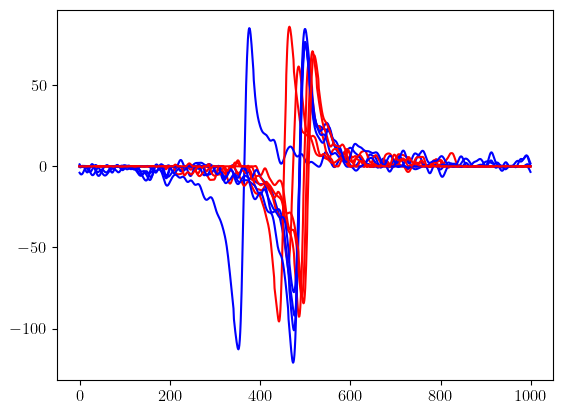

In [222]:
for i in range(5):
    plt.plot(labels_0[i], c = "b")
    plt.plot(labels_1[i], c = "r")

### Diffusion coeff

##### 5 and 10 nm

In [3]:
event_times_all = unpickle("data_1_to_20_df3.pkl")["event_time"]
event_datas_all = unpickle("data_1_to_20_df3.pkl")["event_data"]
mean_noises_all = unpickle("data_1_to_20_df3.pkl")["mean_noise"]
sd_thresholds_all = unpickle("data_1_to_20_df3.pkl")["sd_threshold"]
sd_thresholds_lower_all = unpickle("data_1_to_20_df3.pkl")["sd_threshold_lower"]


In [4]:
event_times_all_5 = event_times_all[:6]
event_datas_all_5 = event_datas_all[:6]
mean_noises_all_5 = mean_noises_all[:6]
sd_thresholds_all_5 = sd_thresholds_all[:6]
sd_thresholds_lower_all_5 = sd_thresholds_lower_all[:6]

event_times_all_10 = event_times_all[6:]
event_datas_all_10 = event_datas_all[6:]
mean_noises_all_10 = mean_noises_all[6:]
sd_thresholds_all_10 = sd_thresholds_all[6:]
sd_thresholds_lower_all_10 = sd_thresholds_lower_all[6:]

In [5]:
def time_between_events(event_times):
    t_between = []
    for i in range(len(event_times) - 1):
        t_diff = event_times[i+1][0] - event_times[i][-1]
        t_between.append(t_diff)
    return t_between

In [6]:
times_between_5 = []
for i in range(len(event_times_all_5)):
    times_between_5 += time_between_events(event_times_all_5[i])

times_between_5 = np.array(times_between_5)

In [7]:
times_between_10 = []
for i in range(len(event_times_all_10)):
    times_between_10 += time_between_events(event_times_all_10[i])
    
times_between_10 = np.array(times_between_10)

In [8]:
from scipy.optimize import curve_fit

In [9]:
def model(t, r1, r2):
    return r1 * np.exp(-r2 * t)

In [242]:
len(event_times_all_5[:]), len(event_times_all_10[:])

(6, 19)

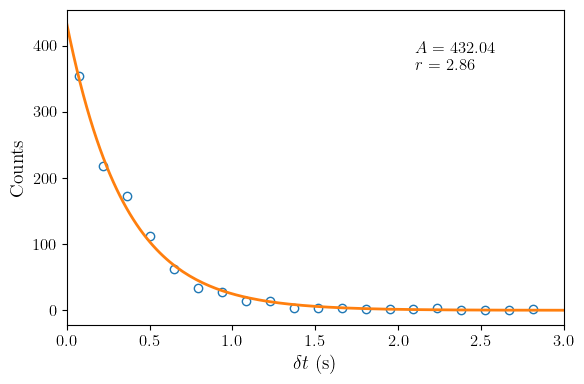

errors 5 nm [9.5636 0.0883]


In [13]:
plt.figure(figsize=(6, 4))

# 5 nm
no_bins = 20
counts, bin_edges = np.histogram(times_between_5, bins=no_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_5, cov_5 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])

plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_5), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_5[0]:.2f}$e^{{-{params_5[1]:.2f}t}}$')
plt.text(0.7, 0.9, f'$A$ = {params_5[0]:.2f}\n$r$ = {params_5[1]:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlim(0, 3)
plt.xlabel('$\delta t$ (s)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
#plt.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig("MSci_python_images/deltaT_5nm.png", dpi=500)
plt.show()

errors_5 = np.sqrt(np.diag(cov_5))
print("errors 5 nm", errors_5)

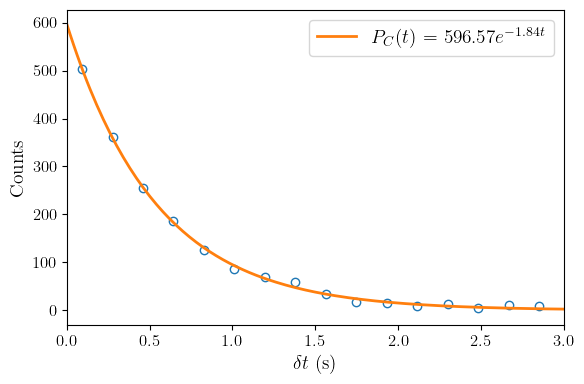

errors 10 nm [2.5577 0.011 ]


In [163]:
plt.figure(figsize=(6, 4))

# 10 nm
no_bins = 100
counts, bin_edges = np.histogram(times_between_10, bins=no_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_10, cov_10 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])

plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_10), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_10[0]:.2f}$e^{{-{params_10[1]:.2f}t}}$')
plt.xlim(0, 3)
plt.xlabel('$\delta t$ (s)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig("MSci_python_images/deltaT_10nm.png", dpi=500)
plt.show()

errors_10 = np.sqrt(np.diag(cov_10))
print("errors 10 nm", errors_10)

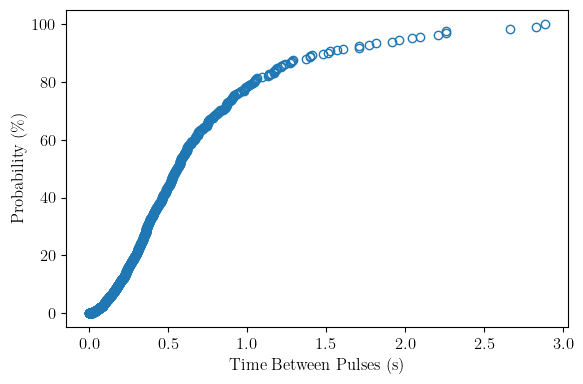

In [239]:
deltaT = times_between_5

plt.figure(figsize=(6, 4))
# Plotting Cumulative Histogram
deltaTsort = np.sort(deltaT)
CumHistdT = np.cumsum(deltaTsort)
CumHistdTnorm = 100 * (CumHistdT / max(CumHistdT))
plt.plot(deltaTsort, CumHistdTnorm, 'o', fillstyle='none', markeredgewidth=1)
plt.xlabel('Time Between Pulses (s)')
plt.ylabel('Probability ($\%$)')

plt.tight_layout()
#plt.savefig("MSci_python_images/deltaT_5nm_cumulative.png", dpi=300)
plt.show()

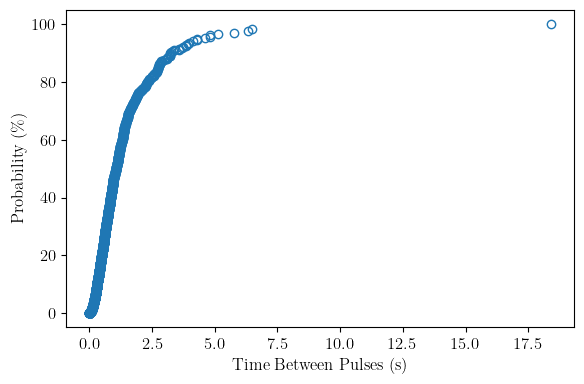

In [238]:
deltaT = times_between_10

plt.figure(figsize=(6, 4))
# Plotting Cumulative Histogram
deltaTsort = np.sort(deltaT)
CumHistdT = np.cumsum(deltaTsort)
CumHistdTnorm = 100 * (CumHistdT / max(CumHistdT))
plt.plot(deltaTsort, CumHistdTnorm, 'o', fillstyle='none', markeredgewidth=1)
plt.xlabel('Time Between Pulses (s)')
plt.ylabel('Probability ($\%$)')

plt.tight_layout()
#plt.savefig("MSci_python_images/deltaT_10nm_cumulative.png", dpi=300)
plt.show()

5 tests

In [348]:
times_between_5

array([0.2711, 0.1315, 0.4823, ..., 0.5785, 0.2606, 0.3577])

python(36866) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36872) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36873) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36874) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36875) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36876) Malloc

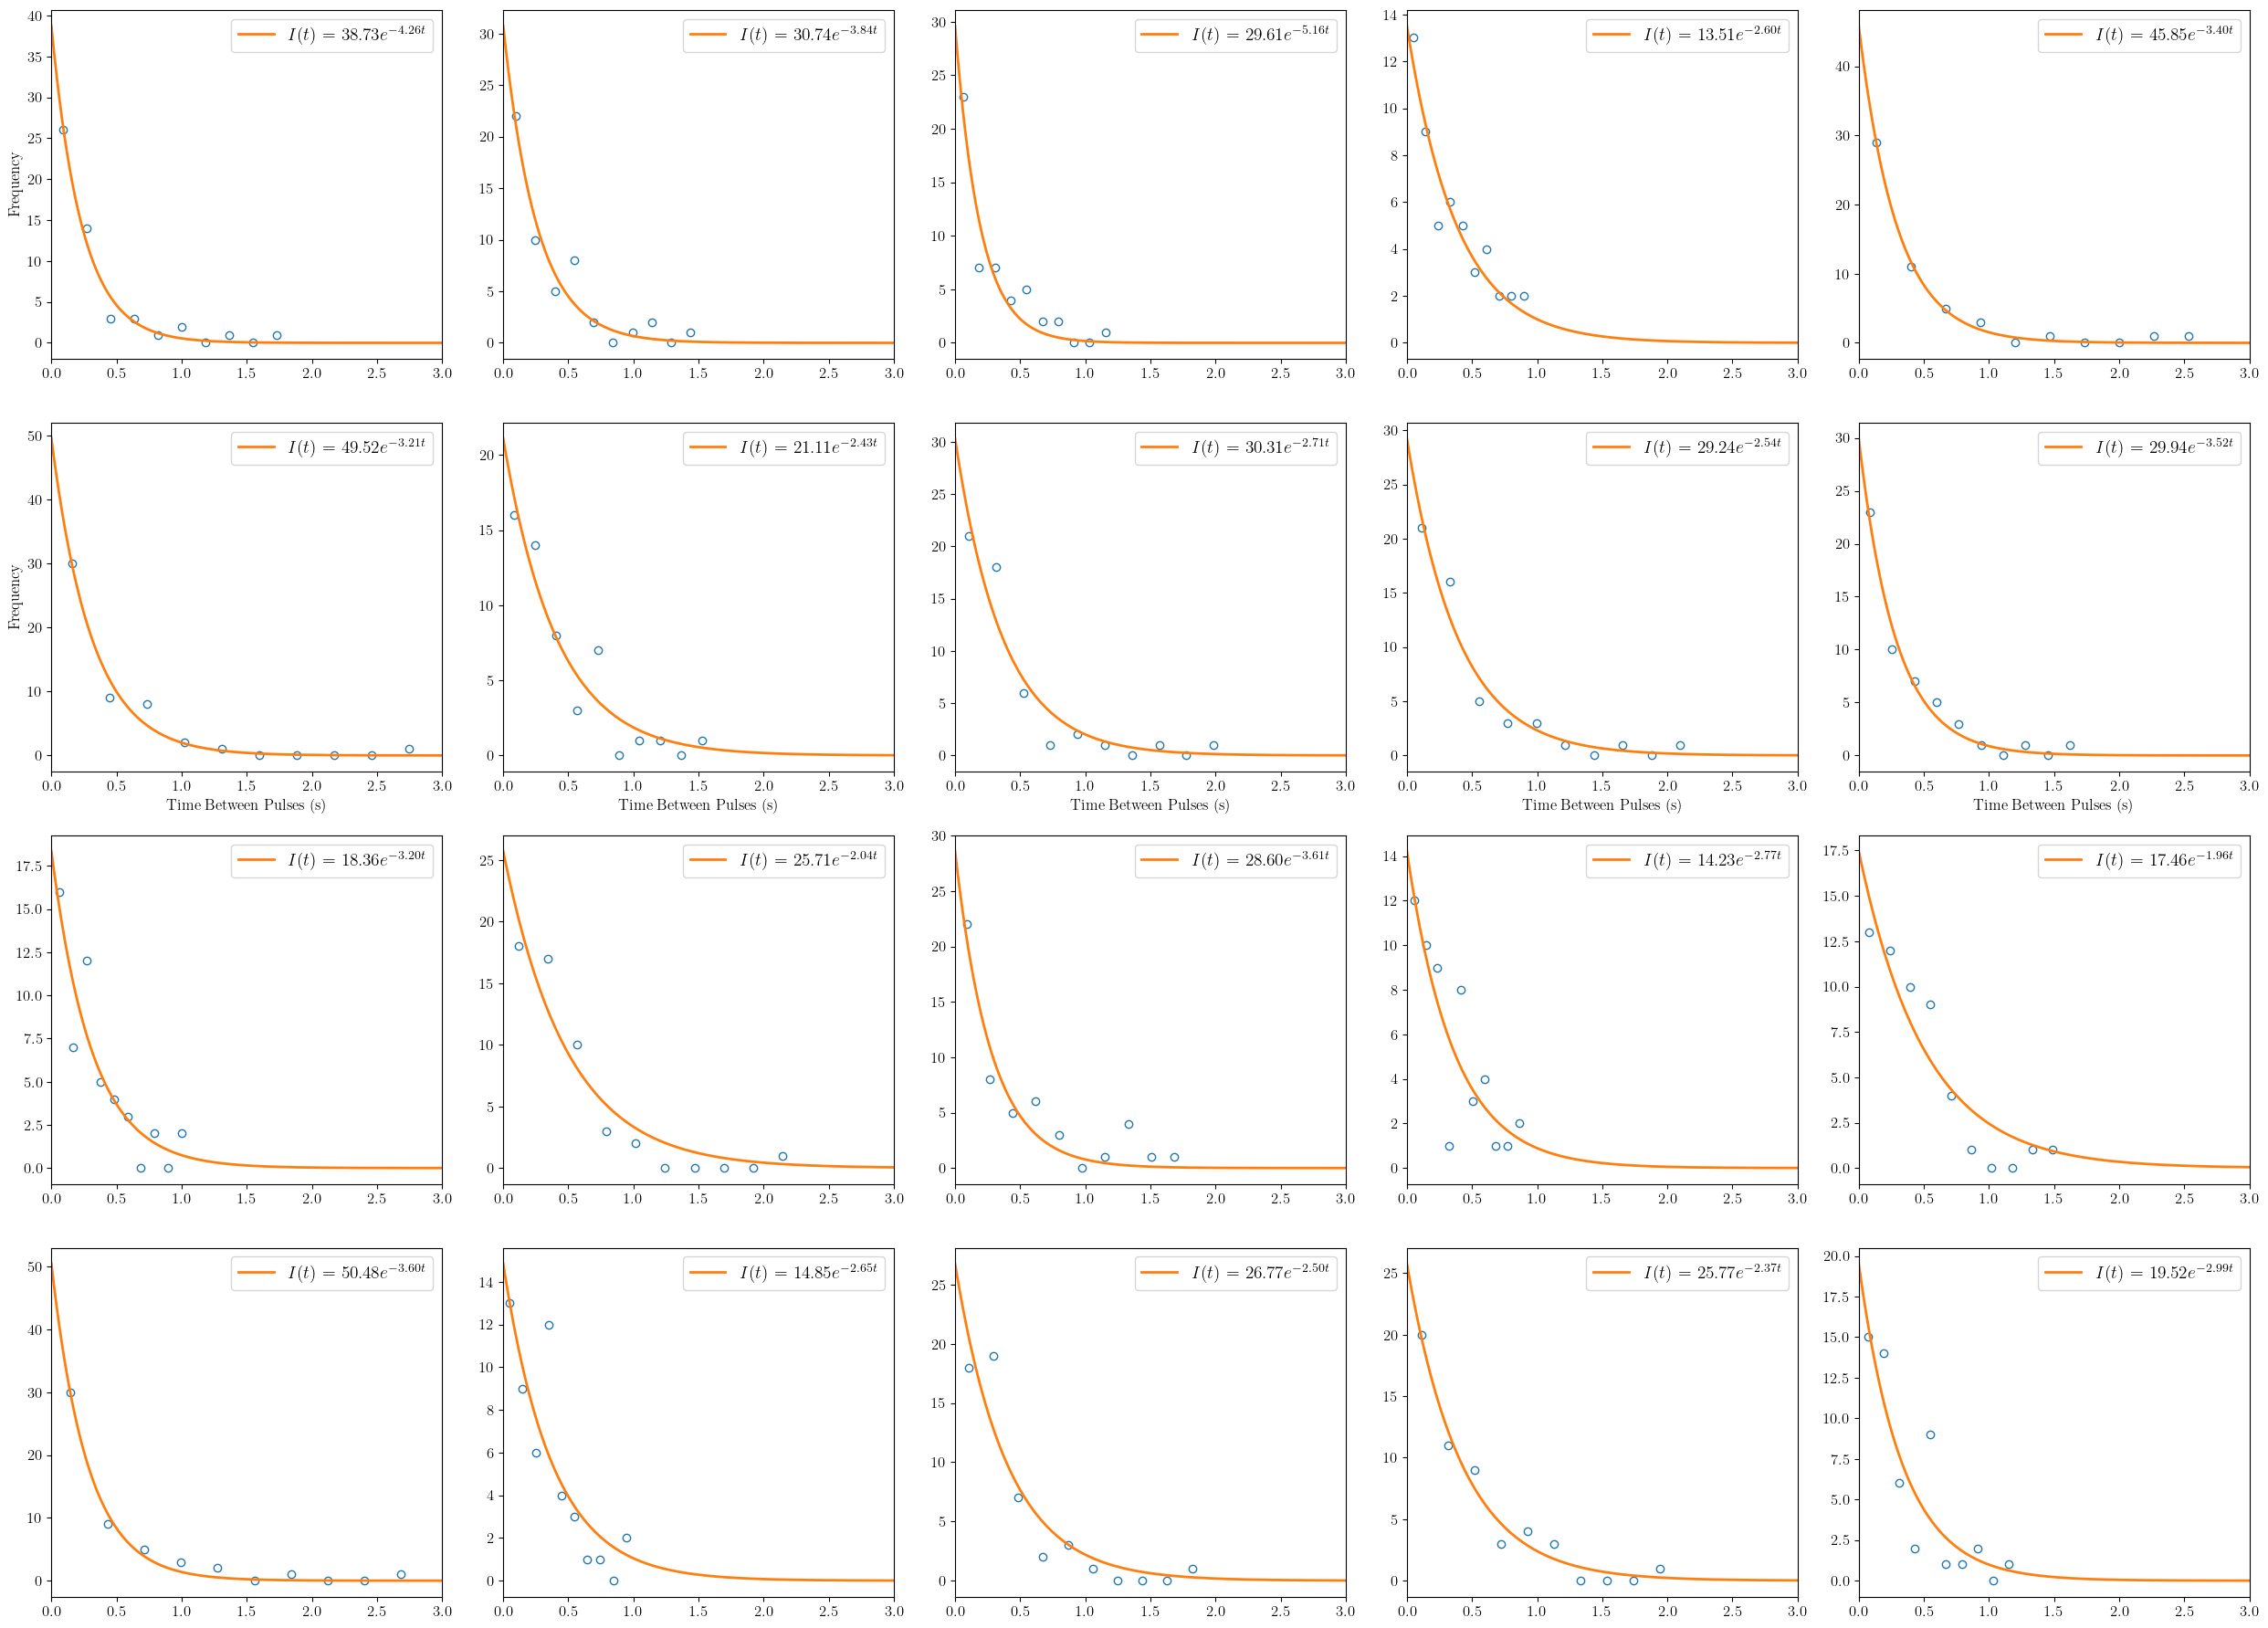

In [435]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 18))
axes = axes.flatten() 

np.random.seed(42)
np.random.shuffle(times_between_5)

no_splits = 20
subset_size = len(times_between_5) // no_splits
subsets = [times_between_5[i*subset_size:(i+1)*subset_size] for i in range(no_splits)]

capture_rate_5_many = []
capture_rate_5_many_errors = []


for i in range(no_splits):
    no_bins = 10
    counts, bin_edges = np.histogram(subsets[i], bins=no_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    params_5_sub, cov_5_sub = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
    capture_rate_5_many.append(params_5_sub[1])
    capture_rate_5_many_errors.append(np.sqrt(np.diag(cov_5_sub))[1])
    
    axes[i].plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
    axes[i].plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_5_sub), color='tab:orange', linewidth=2, label=f'$I(t)$ = {params_5_sub[0]:.2f}$e^{{-{params_5_sub[1]:.2f}t}}$')
    axes[i].set_xlim(0, 3)
    axes[i].legend(fontsize = 14)
    if i in [0, 5]:
        axes[i].set_ylabel('Frequency')
    if i in [5, 6, 7, 8, 9]:
        axes[i].set_xlabel('Time Between Pulses (s)')

plt.tight_layout()
#plt.savefig("MSci_python_images/deltaT_5nm_many.png", dpi=500)
plt.show()

python(36826) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36828) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36829) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36836) Malloc

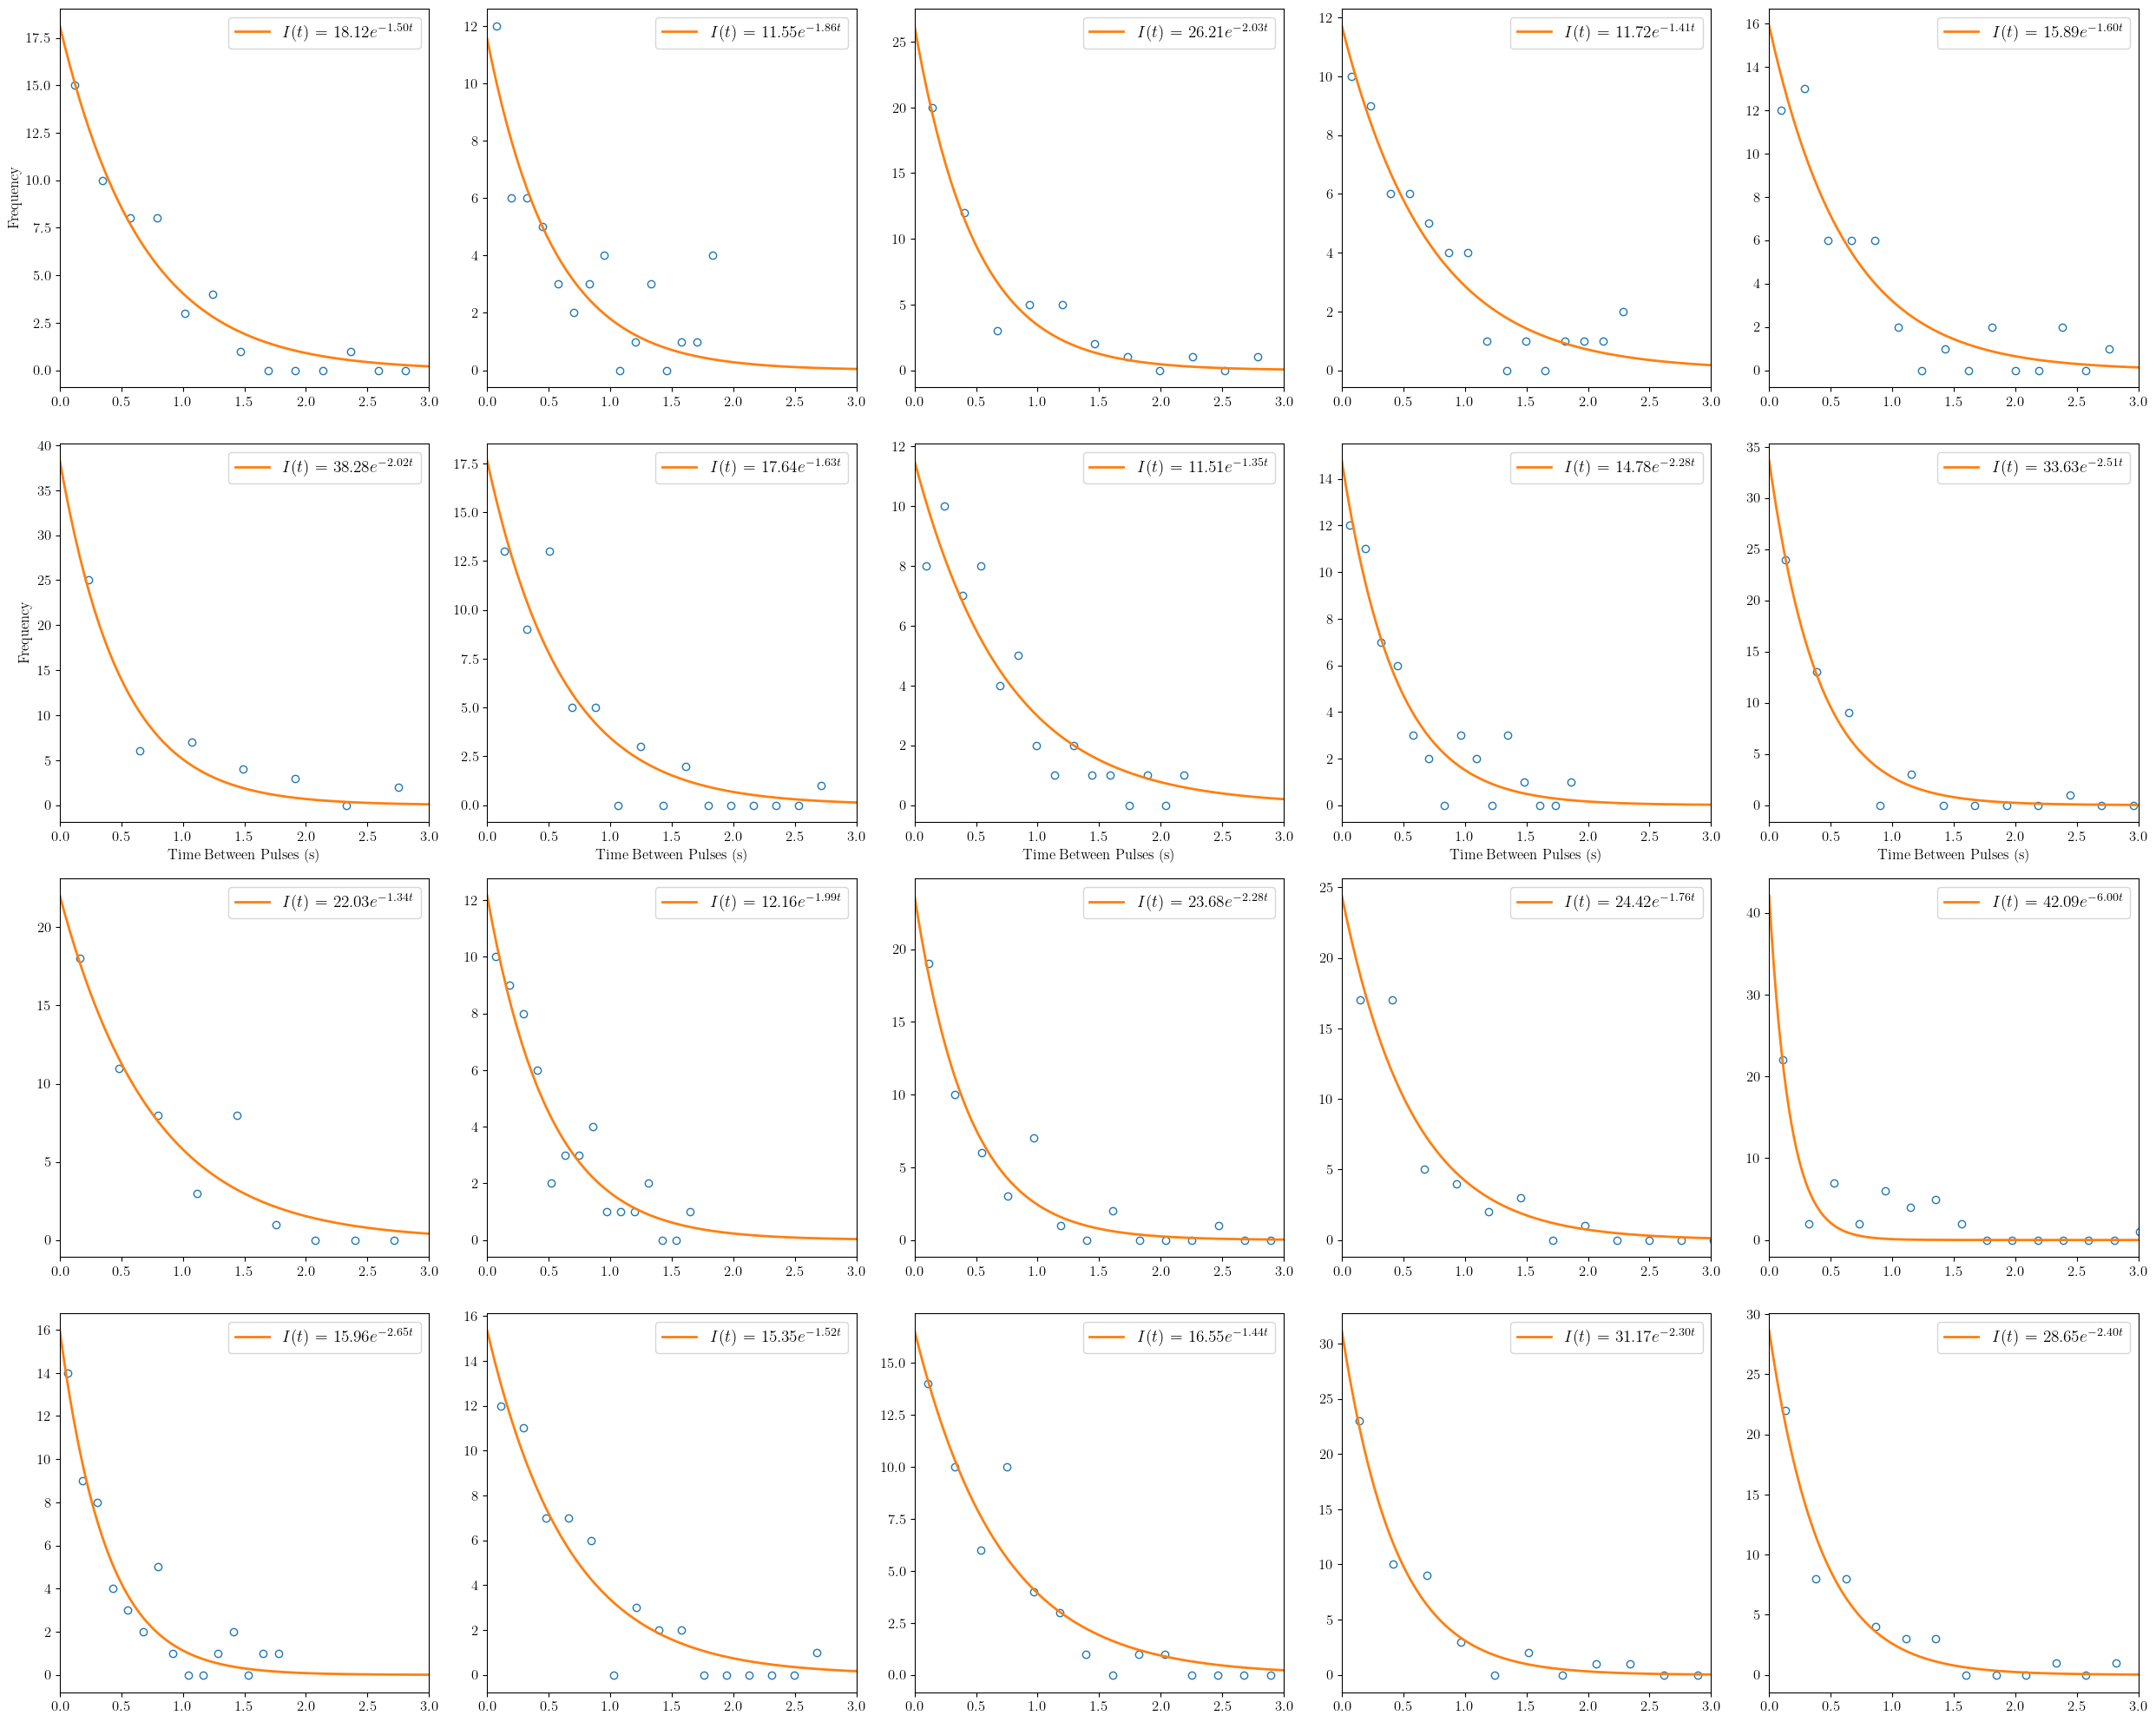

In [434]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
axes = axes.flatten() 

np.random.seed(42)
np.random.shuffle(times_between_10)

no_splits = 20
subset_size = len(times_between_5) // no_splits
subsets = [times_between_10[i*subset_size:(i+1)*subset_size] for i in range(no_splits)]

capture_rate_10_many = []
capture_rate_10_many_errors = []


for i in range(no_splits):
    no_bins = 15
    counts, bin_edges = np.histogram(subsets[i], bins=no_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    params_10_sub, cov_10_sub = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
    capture_rate_10_many.append(params_10_sub[1])
    capture_rate_10_many_errors.append(np.sqrt(np.diag(cov_10_sub))[1])
    
    axes[i].plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
    axes[i].plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_10_sub), color='tab:orange', linewidth=2, label=f'$I(t)$ = {params_10_sub[0]:.2f}$e^{{-{params_10_sub[1]:.2f}t}}$')
    axes[i].set_xlim(0, 3)
    axes[i].legend(fontsize = 14)
    
    if i in [0, 5]:
        axes[i].set_ylabel('Frequency')
    if i in [5, 6, 7, 8, 9]:
        axes[i].set_xlabel('Time Between Pulses (s)')

plt.tight_layout()
#plt.savefig("MSci_python_images/deltaT_10nm_many.png", dpi=500)
plt.show()

In [436]:
ratio_many_5_10 = np.array(capture_rate_5_many) / np.array(capture_rate_10_many)

In [437]:
ratio_many_5_10_errors = ratio_many_5_10 * np.sqrt((np.array(capture_rate_5_many_errors) / np.array(capture_rate_5_many))**2 + (np.array(capture_rate_10_many_errors) / np.array(capture_rate_10_many))**2)

In [178]:
params_5[1], errors_5[1], params_10[1], errors_10[1]

(2.858127985875903,
 0.08831260438844148,
 1.8368145729288397,
 0.011038754442842877)

In [179]:
params_0[1], errors_label_0[1], params_1[1], errors_label_1[1]

(0.6860609228087008,
 0.07815575609956601,
 1.1997581069181595,
 0.040823740531579555)

In [183]:
ratio_5_10 = params_5[1] / params_10[1]
ratio_0_1 = params_1[1] / params_0[1]

error_ratio_5_10 = ratio_5_10 * np.sqrt((errors_5[1] / params_5[1])**2 + (errors_10[1] / params_10[1])**2)
error_ratio_0_1 = ratio_0_1 * np.sqrt((errors_label_0[1] / params_0[1])**2 + (errors_label_1[1] / params_1[1])**2)

print(f"ratio 5/10 {ratio_5_10} $\pm$ {error_ratio_5_10}")
print(f"ratio 0/1 {ratio_0_1} $\pm$ {error_ratio_0_1}")

ratio 5/10 1.5560242323853941 $\pm$ 0.048980174134004455
ratio 0/1 1.748763217713096 $\pm$ 0.20791520762516114


In [170]:
ratio_5_10, ratio_0_1

(1.5560242323853941, 1.748763217713096)

In [440]:
from scipy.stats import normaltest

normaltest(ratio_many_5_10)

NormaltestResult(statistic=0.4851823016545141, pvalue=0.784592228088592)

Error in ratio

In [342]:
ratio_5_10 = 2.87/1.83
error_ratio = ratio_5_10 * ((errors_5[1] / params_5[1]) ** 2 + (errors_10[1] / params_10[1]) ** 2) ** 0.5

print(f"error in 5/10 nm ratio: {ratio_5_10} $\pm$ {error_ratio}")

error in 5/10 nm ratio: 1.5683060109289617 $\pm$ 0.04675379091930936


Welch's t-test

In [473]:
t_stat, p_value = stats.ttest_ind(ratio_many_5_10, ratio_many_0_1, equal_var=False)

print(f"Welch's T-statistic: {t_stat}")
print(f"P-value: {p_value}")

Welch's T-statistic: -0.3131076467279819
P-value: 0.7737277239157059


Average event profile

In [6]:
noDWT_data_padded_all = unpickle("df_noDWT_event_data.pkl")

In [7]:
noDWT_event_data_padded_5 = noDWT_data_padded_all["data"][:6]
noDWT_event_data_padded_10 = noDWT_data_padded_all["data"][6:]
noDWT_event_time_padded_5 = noDWT_data_padded_all["time"][:6]
noDWT_event_time_padded_10 = noDWT_data_padded_all["time"][6:]

# flatten the lists
noDWT_event_data_padded_5 = np.array([item for sublist in noDWT_event_data_padded_5 for item in sublist])
noDWT_event_data_padded_10 = np.array([item for sublist in noDWT_event_data_padded_10 for item in sublist])
noDWT_event_time_padded_5 = np.array([item for sublist in noDWT_event_time_padded_5 for item in sublist])
noDWT_event_time_padded_10 = np.array([item for sublist in noDWT_event_time_padded_10 for item in sublist])

noDWT_event_time_padded_5, noDWT_event_data_padded_5 = centre_peak(noDWT_event_time_padded_5, noDWT_event_data_padded_5, 500)
noDWT_event_time_padded_10, noDWT_event_data_padded_10 = centre_peak(noDWT_event_time_padded_10, noDWT_event_data_padded_10, 500)

In [8]:
average_noDWT_5 = np.mean(noDWT_event_data_padded_5, axis = 0)
average_noDWT_10 = np.mean(noDWT_event_data_padded_10, axis = 0)

In [9]:
std_noDWT_5 = np.std(noDWT_event_data_padded_5, axis = 0,  ddof=1) #/ np.sqrt(len(noDWT_event_data_padded_5)/2)
std_noDWT_10 = np.std(noDWT_event_data_padded_10, axis = 0,  ddof=1) #/ np.sqrt(len(noDWT_event_data_padded_10)/2)

In [27]:
len(noDWT_event_data_padded_5), len(noDWT_event_data_padded_10)

(1038, 1810)

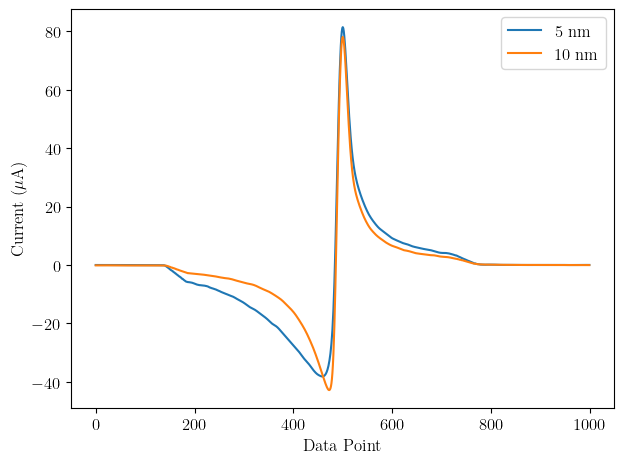

In [10]:
plt.plot(average_noDWT_5, label = "5 nm")
plt.plot(average_noDWT_10, label = "10 nm")
plt.legend()
plt.xlabel("Data Point")
plt.ylabel("Current ($\mu$A)")
plt.tight_layout()
#plt.savefig("MSci_python_images/event_avg_5_10_nm.png", dpi = 300)
plt.show()

In [12]:
np.min(average_noDWT_5), np.min(average_noDWT_10)

(-38.148208954710285, -42.798992471185656)

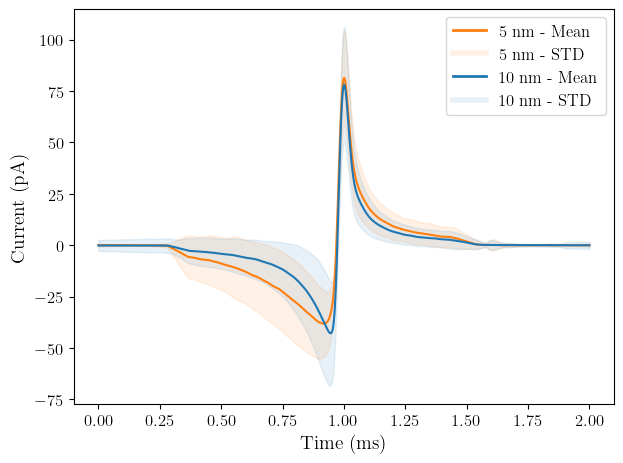

In [14]:

from matplotlib.lines import Line2D


x_values = np.linspace(0, len(average_noDWT_5)* 2e-6 * 1000, len(average_noDWT_5))


plt.plot(x_values, average_noDWT_5, label="5 nm - Mean", color='tab:orange')
plt.fill_between(x_values, 
                 average_noDWT_5 - std_noDWT_5, 
                 average_noDWT_5 + std_noDWT_5, alpha=0.1, color='tab:orange')


plt.plot(x_values, average_noDWT_10, label="10 nm - Mean", color='tab:blue')
plt.fill_between(x_values, 
                 average_noDWT_10 - std_noDWT_10, 
                 average_noDWT_10 + std_noDWT_10, alpha=0.1, color='tab:blue')


# Correcting custom legend entries to match plotted lines and shaded areas
custom_lines = [
    Line2D([0], [0], color='tab:orange', lw=2),  # For "5 nm - Mean"
    Line2D([0], [0], color='tab:orange', lw=4, alpha=0.1),  # For "5 nm - STD"
    Line2D([0], [0], color='tab:blue', lw=2),  # For "10 nm - Mean"
    Line2D([0], [0], color='tab:blue', lw=4, alpha=0.1)  # For "10 nm - STD"
]

# Creating a legend that accurately represents both means and STDs
plt.legend(custom_lines, ['5 nm - Mean', '5 nm - STD', '10 nm - Mean', '10 nm - STD'])

# Adding plot details
plt.xlabel("Time (ms)", fontsize  = 14)
plt.ylabel("Current (pA)", fontsize = 14)
plt.tight_layout()

plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/event_avg_5_10_nm_with_std.png", dpi=500)

plt.show()

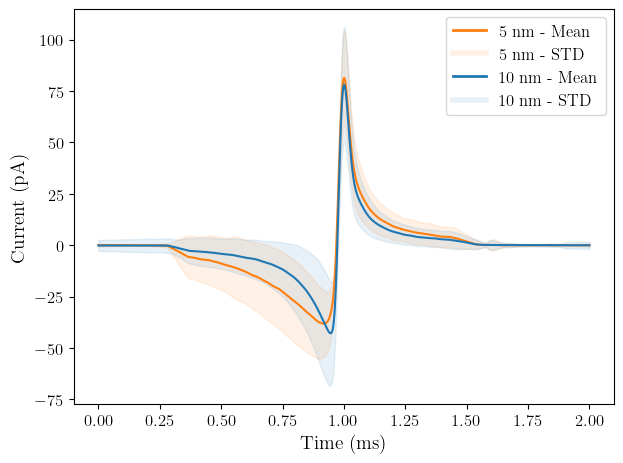

In [12]:

from matplotlib.lines import Line2D


x_values = np.linspace(0, len(average_noDWT_5)* 2e-6 * 1000, len(average_noDWT_5))


plt.plot(x_values, average_noDWT_5, label="5 nm - Mean", color='tab:orange')
plt.fill_between(x_values, 
                 average_noDWT_5 - std_noDWT_5, 
                 average_noDWT_5 + std_noDWT_5, alpha=0.1, color='tab:orange')


plt.plot(x_values, average_noDWT_10, label="10 nm - Mean", color='tab:blue')
plt.fill_between(x_values, 
                 average_noDWT_10 - std_noDWT_10, 
                 average_noDWT_10 + std_noDWT_10, alpha=0.1, color='tab:blue')


# Correcting custom legend entries to match plotted lines and shaded areas
custom_lines = [
    Line2D([0], [0], color='tab:orange', lw=2),  # For "5 nm - Mean"
    Line2D([0], [0], color='tab:orange', lw=4, alpha=0.1),  # For "5 nm - STD"
    Line2D([0], [0], color='tab:blue', lw=2),  # For "10 nm - Mean"
    Line2D([0], [0], color='tab:blue', lw=4, alpha=0.1)  # For "10 nm - STD"
]

# Creating a legend that accurately represents both means and STDs
plt.legend(custom_lines, ['5 nm - Mean', '5 nm - STD', '10 nm - Mean', '10 nm - STD'])

# Adding plot details
plt.xlabel("Time (ms)", fontsize  = 14)
plt.ylabel("Current (pA)", fontsize = 14)
plt.tight_layout()

# plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/event_avg_5_10_nm_with_std.png", dpi=500)

plt.savefig("/Users/joehart/Desktop/1_Imperial/Year 4/MSci project/Python_nanopores/MSci_python_images/event_avg_5_10_nm_with_std.svg")


plt.show()

##### Mixed events
- from many different runs therefore need to only compare the same runs

In [13]:
def time_between_multirun(event_times):
    t_between = []
    for i in range(len(event_times) - 1):
        t_diff = event_times[i+1][0] - event_times[i][-1]
        if t_diff > 0:
            t_between.append(t_diff)
    return t_between

In [29]:
time_between_02_bior33_label_0 = time_between_multirun(time_02_bior33_labels_0)
time_between_02_bior33_label_1 = time_between_multirun(time_02_bior33_labels_1)

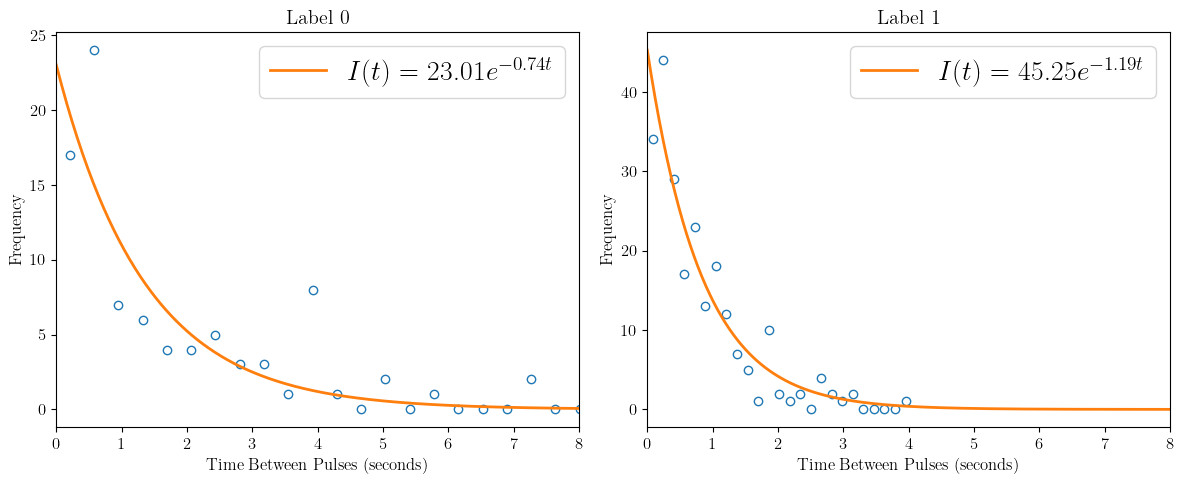

In [30]:
#fig, axs = plt.subplots(2, 1, figsize=(6, 8))  # 2 rows, 1 column
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Data for label 0
no_bins = 25
counts, bin_edges = np.histogram(time_between_02_bior33_label_0, bins=no_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_5, cov_5 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])

# Plot for label 0
axs[0].plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
axs[0].plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_5), color='tab:orange', linewidth=2, label=f'$I(t)$ = {params_5[0]:.2f}$e^{{-{params_5[1]:.2f}t}}$')
axs[0].set_xlim(0, 8)
axs[0].set_title("Label 0")
axs[0].set_xlabel('Time Between Pulses (seconds)')
axs[0].set_ylabel('Frequency')
axs[0].legend(fontsize = 20)

# Data for label 1
no_bins = 25
counts, bin_edges = np.histogram(time_between_02_bior33_label_1, bins=no_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_5, cov_5 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])

# Plot for label 1
axs[1].plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
axs[1].plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_5), color='tab:orange', linewidth=2, label=f'$I(t)$ = {params_5[0]:.2f}$e^{{-{params_5[1]:.2f}t}}$')
axs[1].set_xlim(0, 8)
axs[1].set_title("Label 1")
axs[1].set_xlabel('Time Between Pulses (seconds)')
axs[1].set_ylabel('Frequency')
axs[1].legend(fontsize = 20)

plt.tight_layout()  # Adjust layout to not overlap
#plt.savefig("MSci_python_images/02_bior33_deltaTplot.png", dpi = 300)
plt.show()

In [1]:
# Data for label 0
plt.figure(figsize=(6, 4))
no_bins = 7
counts, bin_edges = np.histogram(time_between_02_bior33_label_0, bins=no_bins, range=(0, 10))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_0, cov_0 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])

# Plot for label 0
plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_0), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_0[0]:.2f}$e^{{-{params_0[1]:.2f}t}}$')
plt.xlim(0, 8)
plt.xlabel('$\delta t$ (s)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig("MSci_python_images/02_bior33_deltaTplot_label_0.png", dpi = 500)
plt.show()

errors_label_0 = np.sqrt(np.diag(cov_0))
print("errors label 0", errors_label_0)
print("params label 0", params_0)

NameError: name 'plt' is not defined

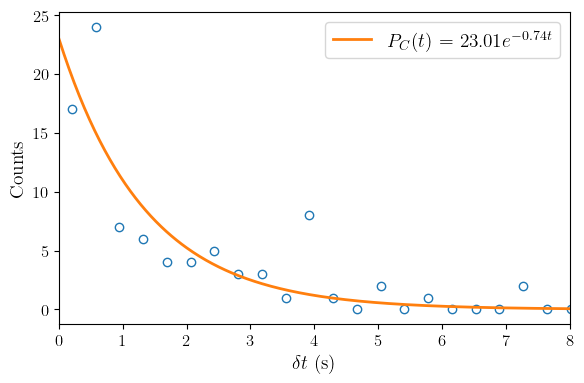

errors label 0 [3.0866 0.1375]


In [107]:
# Data for label 0
plt.figure(figsize=(6, 4))
no_bins = 25
counts, bin_edges = np.histogram(time_between_02_bior33_label_0, bins=no_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_0, cov_0 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])

# Plot for label 0
plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_0), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_0[0]:.2f}$e^{{-{params_0[1]:.2f}t}}$')
plt.xlim(0, 8)
plt.xlabel('$\delta t$ (s)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig("MSci_python_images/02_bior33_deltaTplot_label_0.png", dpi = 300)
plt.show()

errors_label_0 = np.sqrt(np.diag(cov_0))
print("errors label 0", errors_label_0)

label 1

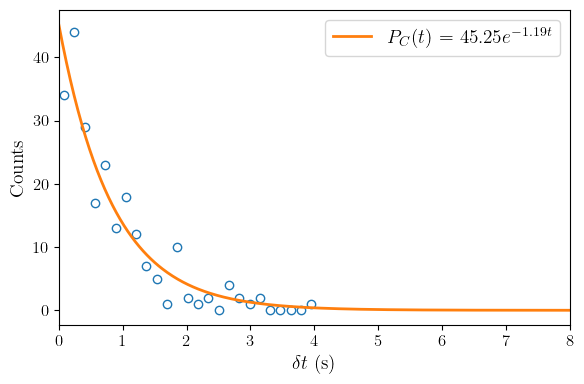

errors label 1 [3.3433 0.1241]


In [108]:
# Data for label 1
plt.figure(figsize=(6, 4))
no_bins = 25
counts, bin_edges = np.histogram(time_between_02_bior33_label_1, bins=no_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_1, cov_1 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])

# Plot for label 1
plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_1), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_1[0]:.2f}$e^{{-{params_1[1]:.2f}t}}$')
plt.xlim(0, 8)
plt.xlabel('$\delta t$ (s)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig("MSci_python_images/02_bior33_deltaTplot_label_1.png", dpi = 300)
plt.show()

errors_label_1 = np.sqrt(np.diag(cov_1))
print("errors label 1", errors_label_1)

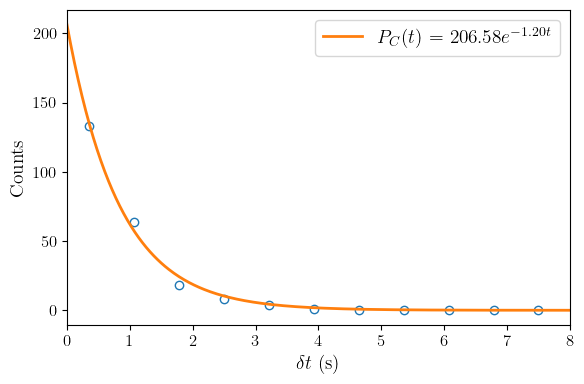

errors label 1 [5.3408 0.0408]


In [182]:
# Data for label 1
plt.figure(figsize=(6, 4))
no_bins = 21
counts, bin_edges = np.histogram(time_between_02_bior33_label_1, bins=no_bins, range=(0, 15))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_1, cov_1 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])

# Plot for label 1
plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_1), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_1[0]:.2f}$e^{{-{params_1[1]:.2f}t}}$')
plt.xlim(0, 8)
plt.xlabel('$\delta t$ (s)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig("MSci_python_images/02_bior33_deltaTplot_label_1.png", dpi = 500)
plt.show()

errors_label_1 = np.sqrt(np.diag(cov_1))
print("errors label 1", errors_label_1)

In [ ]:
params_1[1]

In [180]:
params_0[1], errors_label_0[1], params_1[1], errors_label_1[1]

(0.6860609228087008,
 0.07815575609956601,
 1.1997581069181595,
 0.040823740531579555)

Error in ratio

In [406]:
ratio_0_1 = 1.19/0.74
error_ratio_labels_0_1 = ratio_0_1 * ((errors_label_0[1] / params_0[1]) ** 2 + (errors_label_1[1] / params_1[1]) ** 2) ** 0.5

print(f"error in 5/10 nm ratio: {ratio_0_1} $\pm$ {error_ratio_labels_0_1}")

error in 5/10 nm ratio: 1.6081081081081081 $\pm$ 0.34243107056310007


In [344]:
sigma_Delta_R

0.34560809459895075

In [343]:
Delta_R = ratio_0_1 - ratio_5_10
sigma_Delta_R = (error_ratio_labels_0_1**2 + error_ratio**2)**0.5

# Assess significance
if abs(Delta_R / sigma_Delta_R) > 2:  # Using 2 as a threshold for approximately 95% confidence
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

The difference is not statistically significant.


In [185]:
def plot_many_capturerates(times_between_event, no_splits, no_bins, x_lim, range_bins = None, filename = None):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 7))
    #fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 3.5))
    axes = axes.flatten() 

    np.random.seed(42)
    np.random.shuffle(times_between_event)

    subset_size = len(times_between_event) // no_splits
    subsets = [times_between_event[i*subset_size:(i+1)*subset_size] for i in range(no_splits)]

    capture_rate_many = []
    capture_rate_many_errors = []


    for i in range(no_splits):
        if range_bins is not None:
            counts, bin_edges = np.histogram(subsets[i], bins=no_bins, range=(0,range_bins))
        else:
            counts, bin_edges = np.histogram(subsets[i], bins=no_bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        params_sub, cov_sub = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
        capture_rate_many.append(params_sub[1])
        capture_rate_many_errors.append(np.sqrt(np.diag(cov_sub))[1])
        
        axes[i].plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
        axes[i].plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_sub), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_sub[0]:.2f}$e^{{-{params_sub[1]:.2f}t}}$')
        axes[i].set_xlim(x_lim[0], x_lim[1])
        axes[i].legend(fontsize = 14)
        
        if i in [0, 5]:
            axes[i].set_ylabel('Counts', fontsize = 14)
        if i in [5, 6, 7, 8, 9]:
            axes[i].set_xlabel('$\delta t$ (s)', fontsize = 14)
        
    plt.tight_layout()
    if filename is not None:
        plt.savefig(f"MSci_python_images/{filename}.png", dpi=500)
    plt.show()
    
    return #capture_rate_many, capture_rate_many_errors

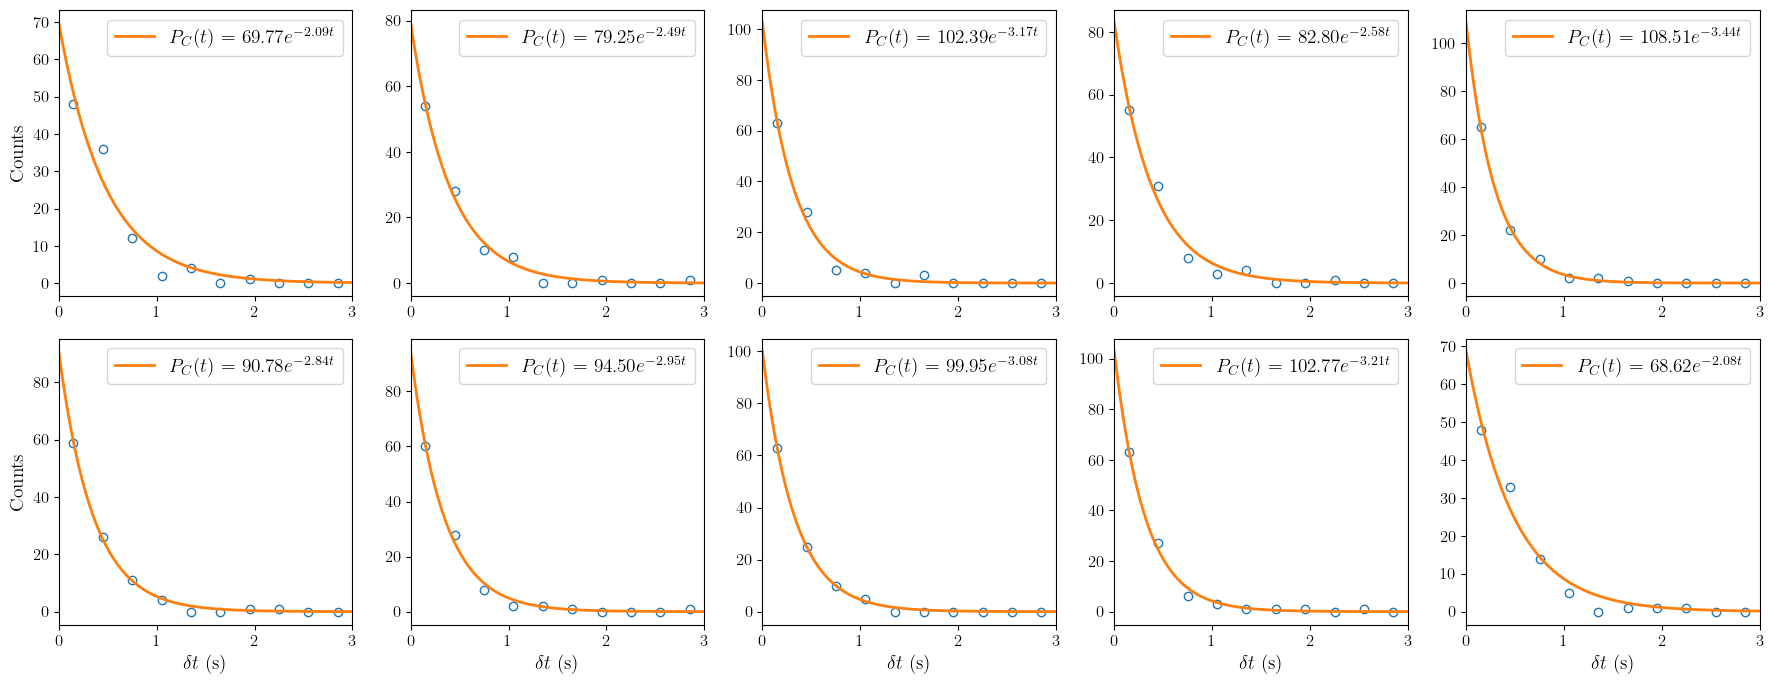

In [186]:
plot_many_capturerates(times_between_5, 10, 10, x_lim=(0, 3), range_bins=3, filename="deltaT_5nm_many")

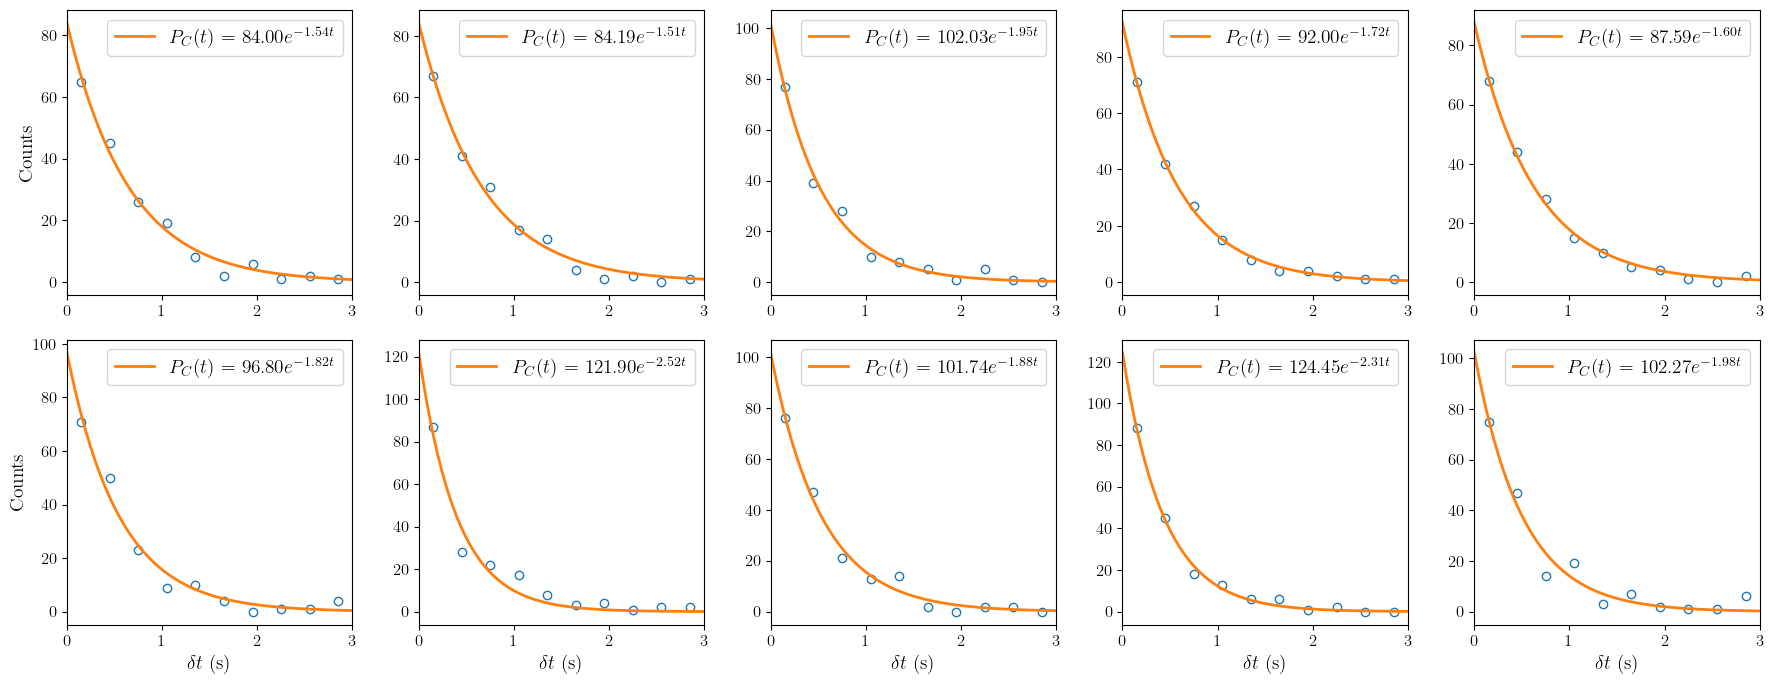

In [187]:
plot_many_capturerates(times_between_10, 10, 10, x_lim=(0, 3), range_bins=3, filename="deltaT_10nm_many")

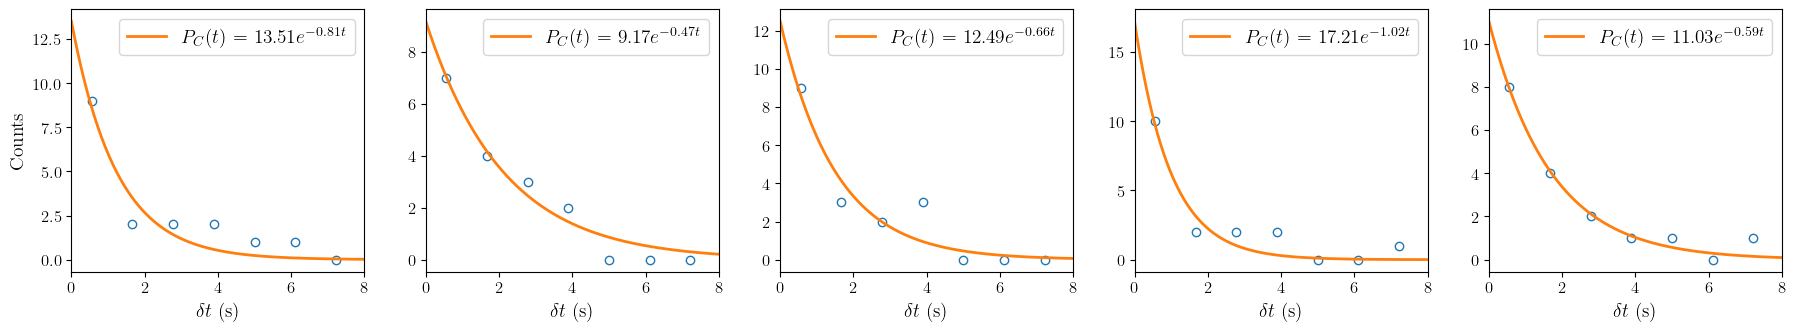

([0.8104205186730021,
  0.47273210234831997,
  0.6620401403407771,
  1.017083959450721,
  0.5934588364497849],
 [0.18403217711113545,
  0.06838900102063568,
  0.13479720726685784,
  0.2259319059048222,
  0.05302405570209481])

In [81]:
plot_many_capturerates(time_between_02_bior33_label_0, 5, 9, x_lim=(0, 8), range_bins=10 , filename="deltaT_5_10_label_0_many")

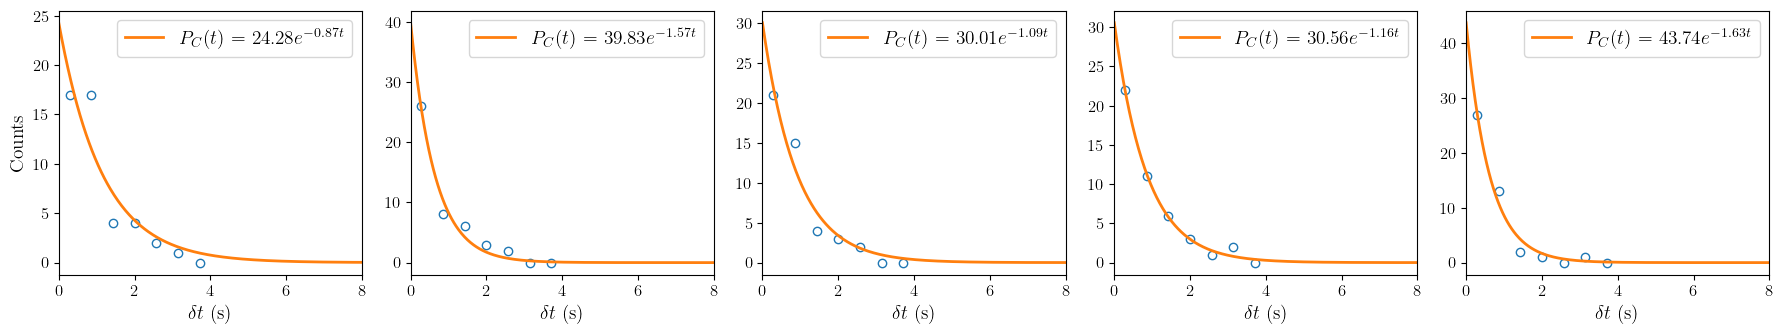

([0.8673919999484946,
  1.5689152613236705,
  1.0915843649341541,
  1.163739974193211,
  1.6296293300710294],
 [0.23162545561829798,
  0.20280669847689983,
  0.1713039724768299,
  0.06283013995889726,
  0.19083640551245257])

In [83]:
plot_many_capturerates(time_between_02_bior33_label_1, 5, 7, x_lim=(0,8), range_bins=4, filename="deltaT_5_10_label_1_many")

##### Average event profile

In [273]:
avg_DWT_rec_02_bior33_labels_0 = np.mean(DWT_rec_02_bior33_labels_0, axis = 0)
avg_DWT_rec_02_bior33_labels_1 = np.mean(DWT_rec_02_bior33_labels_1, axis = 0)

In [277]:
std_DWT_rec_02_bior33_labels_0 = np.std(DWT_rec_02_bior33_labels_0, axis=0) / np.sqrt(len(DWT_rec_02_bior33_labels_0))
std_DWT_rec_02_bior33_labels_1 = np.std(DWT_rec_02_bior33_labels_1, axis=0) / np.sqrt(len(DWT_rec_02_bior33_labels_1))

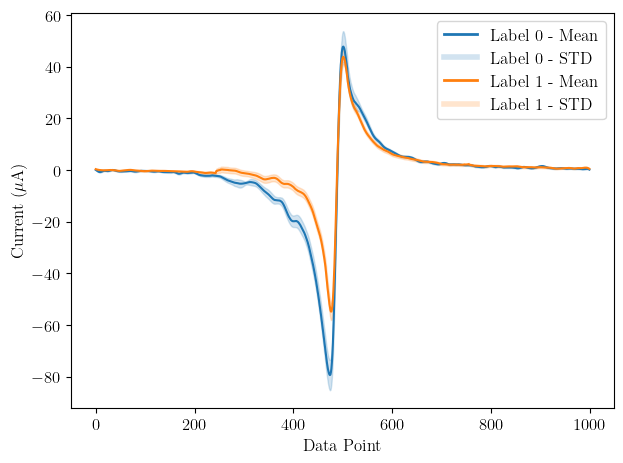

In [298]:
plt.plot(avg_DWT_rec_02_bior33_labels_0, label="Label 0 - Mean", color='tab:blue')
plt.fill_between(range(len(avg_DWT_rec_02_bior33_labels_0)), 
                 avg_DWT_rec_02_bior33_labels_0 - std_DWT_rec_02_bior33_labels_0, 
                 avg_DWT_rec_02_bior33_labels_0 + std_DWT_rec_02_bior33_labels_0, alpha=0.2, color='tab:blue')

plt.plot(avg_DWT_rec_02_bior33_labels_1, label="Label 1 - Mean", color='tab:orange')
plt.fill_between(range(len(avg_DWT_rec_02_bior33_labels_1)), 
                 avg_DWT_rec_02_bior33_labels_1 - std_DWT_rec_02_bior33_labels_1, 
                 avg_DWT_rec_02_bior33_labels_1 + std_DWT_rec_02_bior33_labels_1, alpha=0.2, color='tab:orange')

# Creating custom legend entries
custom_lines = [
    Line2D([0], [0], color='tab:blue', lw=2),  # Mean - Label 0
    Line2D([0], [0], color='tab:blue', lw=4, alpha=0.2),  # STD - Label 0
    Line2D([0], [0], color='tab:orange', lw=2),  # Mean - Label 1
    Line2D([0], [0], color='tab:orange', lw=4, alpha=0.2)  # STD - Label 1
]

# Updating legend to include both means and STDs
plt.legend(custom_lines, ['Label 0 - Mean', 'Label 0 - STD', 'Label 1 - Mean', 'Label 1 - STD'])

# Adding the rest of the plot details
plt.xlabel("Data Point")
plt.ylabel("Current ($\mu$A)")
plt.tight_layout()
#plt.savefig("MSci_python_images/event_avg_label_0_1_02_bior33_with_std.png", dpi = 500)
plt.show()



python(37245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37247) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37248) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37250) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


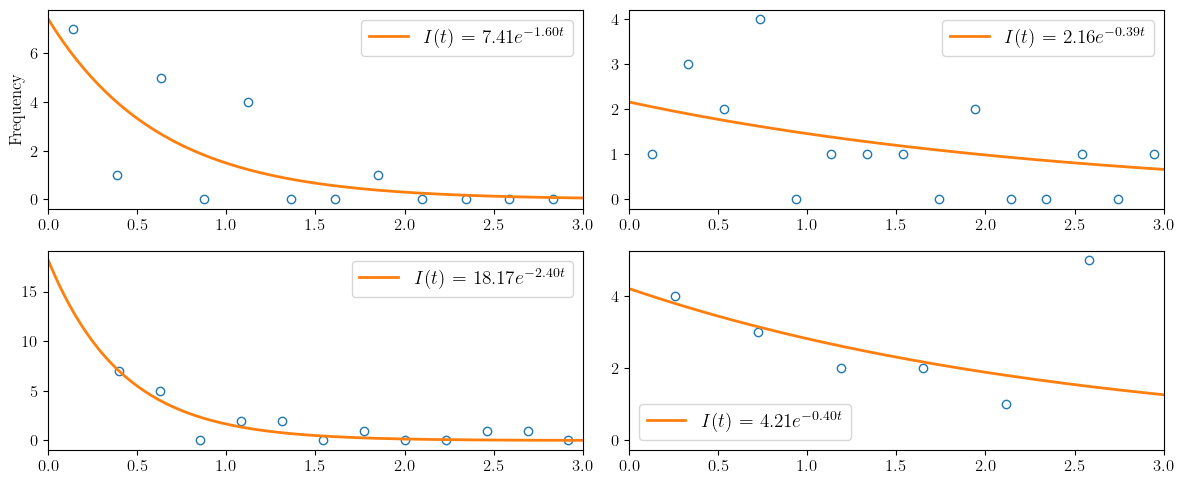

In [470]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
axes = axes.flatten() 

np.random.seed(42)
np.random.shuffle(time_between_02_bior33_label_0)

no_splits = 4
subset_size = len(time_between_02_bior33_label_0) // no_splits
subsets = [time_between_02_bior33_label_0[i*subset_size:(i+1)*subset_size] for i in range(no_splits)]

capture_rate_0_many = []
capture_rate_0_many_errors = []


for i in range(no_splits):
    no_bins = 20
    counts, bin_edges = np.histogram(subsets[i], bins=no_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    params_0_sub, cov_0_sub = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
    capture_rate_0_many.append(params_0_sub[1])
    capture_rate_0_many_errors.append(np.sqrt(np.diag(cov_0_sub))[1])
    
    axes[i].plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
    axes[i].plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_0_sub), color='tab:orange', linewidth=2, label=f'$I(t)$ = {params_0_sub[0]:.2f}$e^{{-{params_0_sub[1]:.2f}t}}$')
    axes[i].set_xlim(0, 3)
    axes[i].legend(fontsize = 14)
    if i in [0, 5]:
        axes[i].set_ylabel('Frequency')
    if i in [5, 6, 7, 8, 9]:
        axes[i].set_xlabel('Time Between Pulses (s)')

plt.tight_layout()
#plt.savefig("MSci_python_images/deltaT_5nm_many.png", dpi=500)
plt.show()

python(37253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37259) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37260) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


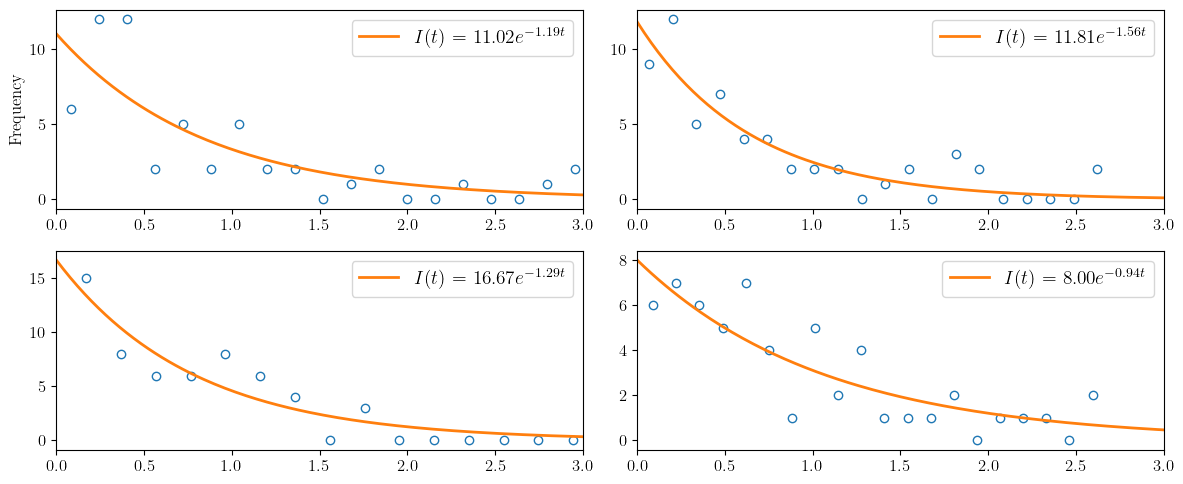

In [471]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,  5))
axes = axes.flatten() 

np.random.seed(42)
np.random.shuffle(time_between_02_bior33_label_1)

no_splits = 4
subset_size = len(time_between_02_bior33_label_1) // no_splits
subsets = [time_between_02_bior33_label_1[i*subset_size:(i+1)*subset_size] for i in range(no_splits)]

capture_rate_1_many = []
capture_rate_1_many_errors = []


for i in range(no_splits):
    no_bins = 20
    counts, bin_edges = np.histogram(subsets[i], bins=no_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    params_1_sub, cov_1_sub = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
    capture_rate_1_many.append(params_1_sub[1])
    capture_rate_1_many_errors.append(np.sqrt(np.diag(cov_1_sub))[1])
    
    axes[i].plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
    axes[i].plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_1_sub), color='tab:orange', linewidth=2, label=f'$I(t)$ = {params_1_sub[0]:.2f}$e^{{-{params_1_sub[1]:.2f}t}}$')
    axes[i].set_xlim(0, 3)
    axes[i].legend(fontsize = 14)
    if i in [0, 5]:
        axes[i].set_ylabel('Frequency')
    if i in [5, 6, 7, 8, 9]:
        axes[i].set_xlabel('Time Between Pulses (s)')

plt.tight_layout()
#plt.savefig("MSci_python_images/deltaT_5nm_many.png", dpi=500)
plt.show()

In [472]:
ratio_many_0_1 = np.array(capture_rate_1_many) / np.array(capture_rate_0_many)
ratio_many_0_1_errors = ratio_many_0_1 * np.sqrt((np.array(capture_rate_0_many_errors) / np.array(capture_rate_0_many))**2 + (np.array(capture_rate_1_many_errors) / np.array(capture_rate_1_many))**2)


### Comments

- dwell time vs peak amplitude distributions for each class